In [1]:
import matplotlib as mlt
import matplotlib.pyplot as plt

import numpy as np
import cv2
from utils import *

%matplotlib inline
mlt.rcParams['figure.figsize'] = (15,8)

# Template matching

[Template matching](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html) is a technique used to find the location of a template image in a larger image. The basic way to do this is to slide the template image on the larger image and compare the pixel patches using different possible comparison methods. Let's implement this using a Mario game screenshot, taken from [here](https://www.pinterest.ca/pin/451415562640336222/).

(463, 720)
(170, 220)


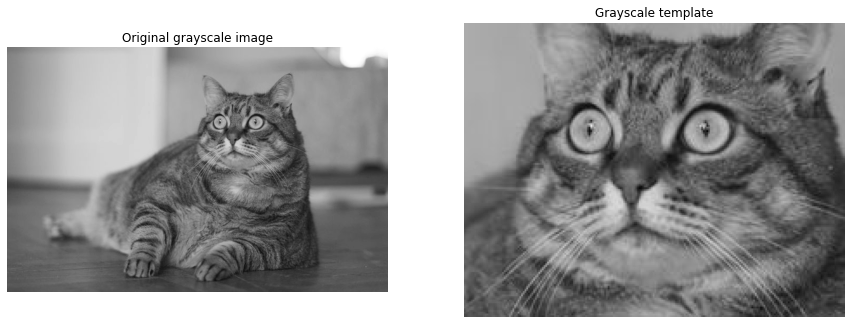

In [2]:
img_gray = cv2.imread('data/cat.jpeg', 0)
print(img_gray.shape)

img_gray_template = img_gray[80:250, 330: 550]
print(img_gray_template.shape)

plot_2_images(img_gray, img_gray_template, "gray", "Original grayscale image", "Grayscale template")

As we can see the template appears three times in the image, twice in the sky and once surrounding by two other brick boxes. We can try to implement a simple comparison as described [here](https://en.wikipedia.org/wiki/Template_matching) using cross correlation or the sum of absolute differences of intensities to compare pixel patches.

## 1. Comparison methods
### 1.1 Cross correlation

Measure of similarity beween two matrices defined by first multiplying the matrices element wise and then summing the coefficients of the result.

In [3]:
def cross_correlation_step(mat1, mat2):
    return np.sum(np.multiply(mat1.astype(np.float32), mat2.astype(np.float32)))

def cross_correlation(template, image):
    
    h, w = image.shape
    print("Original image shape : {}".format((h, w)))
    th, tw = template.shape
    print("Template image shape : {}".format((th, tw)))
    
    # drop border cases (done like this in opencv, we could also pad)
    cross_correlation = np.empty((h - th + 1, w - tw + 1))
    
    for i in range(h - th):
        for j in range(w - tw):
            patch = image[i:i+th, j:j+tw]
            cross_correlation[i, j] = cross_correlation_step(template, patch)
    
    print("Cross correlation image shape : {}".format(cross_correlation.shape))
    return cross_correlation

Alternatively we can use the openCv implementation : <code>cv2.matchTemplate(img_gray, img_gray_template, cv2.TM_CCORR)</code> which is much more optimized ! Let's roll with this one for the next steps (since we dropped the border cases the outputs of the two methods are identical when using <code>cv2.TM_CCORR</code> as comparison method).

In [4]:
%%time
cc_map = cross_correlation(img_gray_template, img_gray)

Original image shape : (463, 720)
Template image shape : (170, 220)
Cross correlation image shape : (294, 501)
Wall time: 36.7 s


In [5]:
%%time
cc_map = cv2.matchTemplate(img_gray.astype(np.float32), img_gray_template.astype(np.float32), cv2.TM_CCORR)

Wall time: 15.8 ms


Let's visualize the matching results.

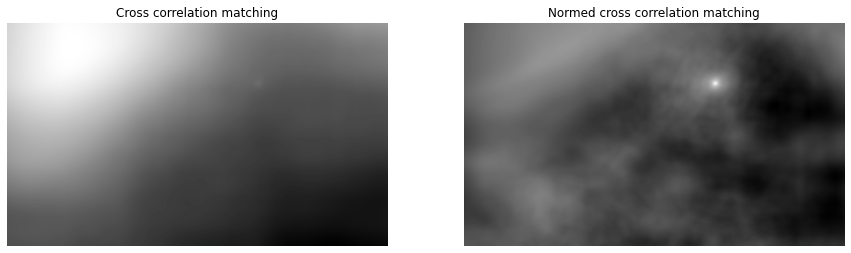

In [6]:
plt.subplot(1, 2, 1)
plt.title("Cross correlation matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_CCORR), cmap = "gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Normed cross correlation matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_CCORR_NORMED), cmap = "gray")
plt.axis('off')
plt.show()

### 1.2 Other comparison methods

There are other possible methods of comparison (details and formulas [here](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html)). Mainly we have :
* Cross correlation (and normed version, already seen above)
* Correlation coefficient
* Squared difference

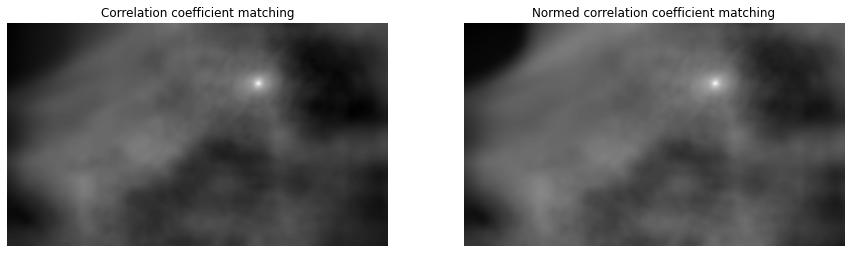

In [7]:
plt.subplot(1, 2, 1)
plt.title("Correlation coefficient matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_CCOEFF), cmap = "gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Normed correlation coefficient matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_CCOEFF_NORMED), cmap = "gray")
plt.axis('off')
plt.show()

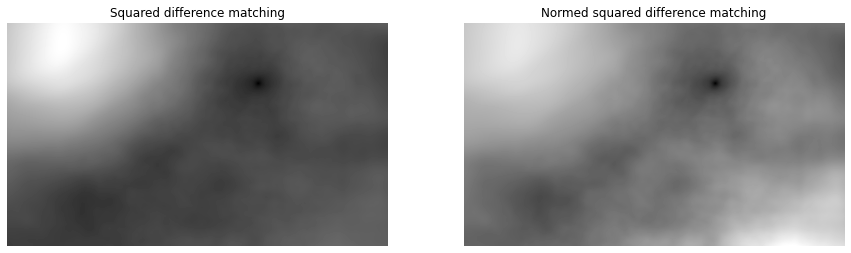

In [8]:
plt.subplot(1, 2, 1)
plt.title("Squared difference matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_SQDIFF), cmap = "gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Normed squared difference matching")
plt.imshow(cv2.matchTemplate(img_gray.astype(np.float32), 
                             img_gray_template.astype(np.float32), 
                             cv2.TM_SQDIFF_NORMED), cmap = "gray")
plt.axis('off')
plt.show()

## 2. Locating the best match

The next step would be locating the maximal (or minimal if we use squared difference) response zones by thresholding the cross correlation map. If we are looking for only one object we need to locate a max/min, we can use openCv method implementation of <code>cv2.minMaxLoc</code>. If we are looking for multiple objects we look for multiple max/mins so we can use thresholding operations.

### 2.1 Locating a single instance of the template

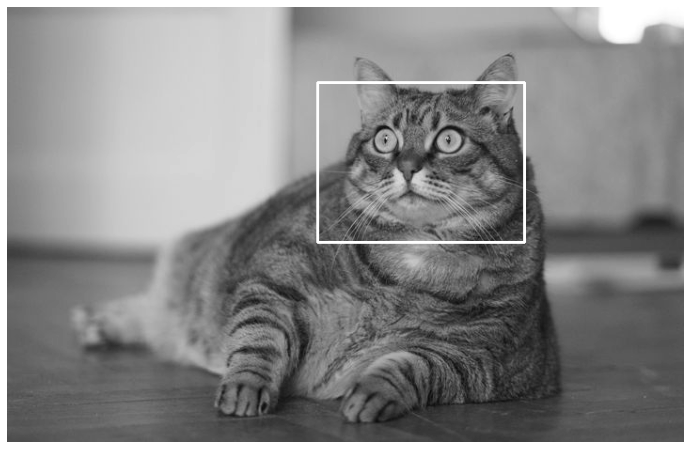

In [9]:
img = img_gray.copy()
th, tw = img_gray_template.shape
matching = cv2.matchTemplate(img, img_gray_template, cv2.TM_CCOEFF_NORMED)

# Usage of minmax (cf. tutorial on website)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching)
top_left = max_loc
bottom_right = (top_left[0] + tw, top_left[1] + th)
# === 

cv2.rectangle(img, top_left, bottom_right, 255, 2)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

### 2.2 Locating multiple objects

(566, 877, 3)
(55, 55, 3)


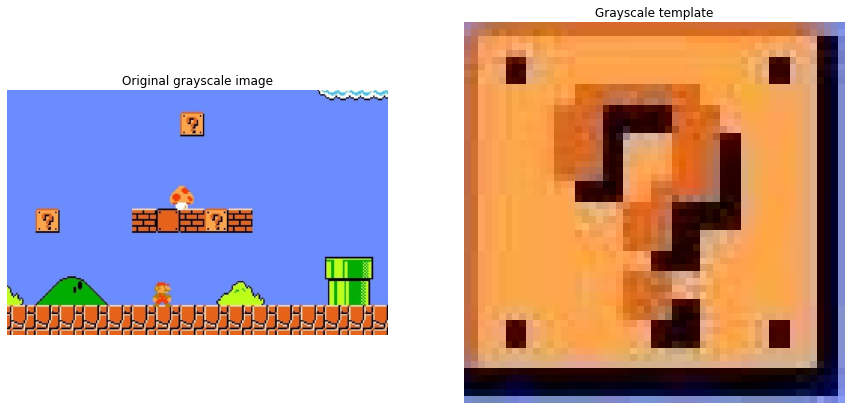

In [18]:
img_rgb = cv2.cvtColor(cv2.imread('data/mario.jpg', 1), cv2.COLOR_BGR2RGB)
print(img_rgb.shape)

img_rgb_template = img_rgb[55:110, 400: 455]
print(img_rgb_template.shape)

plot_2_images(img_rgb, img_rgb_template, "rgb", "Original grayscale image", "Grayscale template")

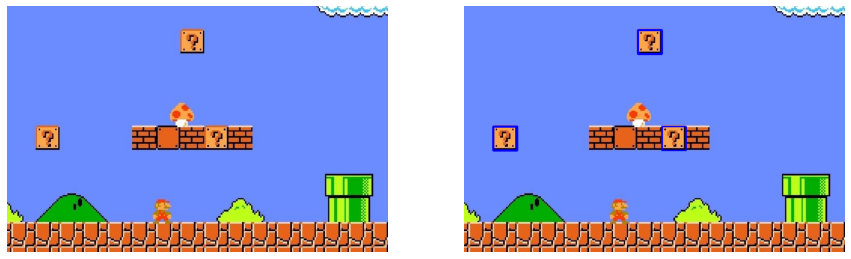

In [21]:
img = img_rgb.copy()
th, tw, _ = img_rgb_template.shape
matching = cv2.matchTemplate(img, img_rgb_template, cv2.TM_CCOEFF_NORMED)

# Usage of thresholding (cf. tutorial on website)
thresh = 0.8
loc = np.where( matching >= thresh)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img, pt, (pt[0] + tw, pt[1] + th), (0,0,255), 2)
# ===
    
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
plt.show()

## 3. Using templates not present in the image